# Предварительный анализ данных по проекту - влияние условий жизни учащихся на их успеваемость по математике

## Задача проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
%matplotlib inline

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Загружаем набор
stud = pd.read_csv('stud_math.xls')
stud.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


In [3]:
# Удалим дублирующиеся строки (если они есть)
stud.drop_duplicates(inplace=True)

In [4]:
# Теперь можно на него посмотреть
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [5]:
# Целевая переменная содержит пропуски - эти строки можно удалить
stud.dropna(subset=['score'], inplace=True)
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               389 non-null    object 
 1   sex                  389 non-null    object 
 2   age                  389 non-null    int64  
 3   address              374 non-null    object 
 4   famsize              362 non-null    object 
 5   Pstatus              344 non-null    object 
 6   Medu                 386 non-null    float64
 7   Fedu                 365 non-null    float64
 8   Mjob                 370 non-null    object 
 9   Fjob                 353 non-null    object 
 10  reason               372 non-null    object 
 11  guardian             358 non-null    object 
 12  traveltime           361 non-null    float64
 13  studytime            382 non-null    float64
 14  failures             367 non-null    float64
 15  schoolsup            380 non-null    obj

In [6]:
# В задании не описан столбец 'studytime, granular' посмотрим на его корелляцию с другими признаками
stud.corr()['studytime, granular']

age                    0.018227
Medu                  -0.081032
Fedu                  -0.059618
traveltime             0.105910
studytime             -1.000000
failures               0.181947
studytime, granular    1.000000
famrel                -0.046249
freetime               0.125066
goout                  0.053831
health                 0.079180
absences               0.025707
score                 -0.115741
Name: studytime, granular, dtype: float64

In [7]:
# Видим, что признак 'studytime, granular' отрицательно коррелирован с 'studytime' - удаляем его
stud.drop('studytime, granular', axis=1, inplace=True)
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   Pstatus     344 non-null    object 
 6   Medu        386 non-null    float64
 7   Fedu        365 non-null    float64
 8   Mjob        370 non-null    object 
 9   Fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  361 non-null    float64
 13  studytime   382 non-null    float64
 14  failures    367 non-null    float64
 15  schoolsup   380 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        350 non-null    object 
 18  activities  375 non-null    object 
 19  nursery     374 non-null    o

In [8]:
# Из всех признаков числовыми я бы назвал только age, absences, score
# остальне номинативные
num_features = ['age', 'absences', 'score']
nom_features = list(set(stud.columns) - set(num_features))

## Исследование числовых признаков

In [9]:
def describe(feature):
    display(stud[feature].describe())
    print(f'Количество пропусков: {stud[feature].isna().sum()}')
    print(
        f'Процент пропусков: {round((stud[feature].isna().sum() / len(stud[feature])) * 100, 2)}%')


def outliers(feature):
    # Интерквартильный размах
    perc25 = stud[feature].quantile(0.25)
    perc75 = stud[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return stud[(stud[feature] < low) | (stud[feature] > high)]


def hist(feature):
    fig, ax = plt.subplots()
    #  Добавляем подписи к осям:
    ax.set_xlabel(feature)
    ax.set_ylabel('count')
    ax.set_title(f'Гистограмма распределения признака {feature}')
    _ = stud[feature].hist(bins=80)


def boxplot(feature):
    fig, ax = plt.subplots()
    ax.set_title(f'Boxplot признака {feature}')
    _ = sns.boxplot(x=stud[feature], ax=ax)

### score — баллы по госэкзамену по математике

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Количество пропусков: 0
Процент пропусков: 0.0%
25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0, Границы выбросов: [-5.0, 115.0]
Выбросы не обнаружены


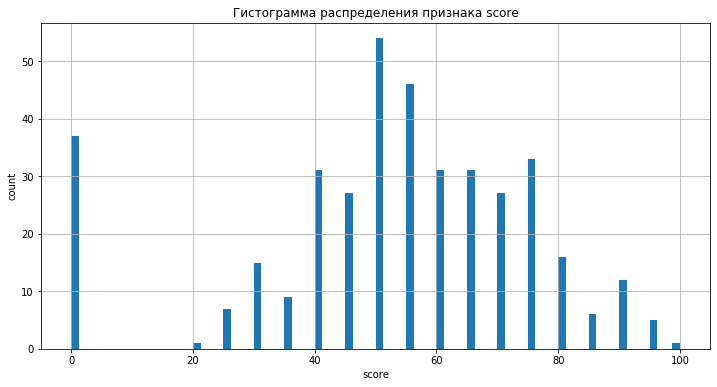

In [10]:
describe('score')
hist('score')

out_df = outliers('score')
if not out_df.empty:
    print('Обнаружены выбросы:')
    display(out_df)
else:
    print('Выбросы не обнаружены')

In [11]:
# Очень много значений score = 0
print(f'Количество score равных 0: {len(stud[stud["score"] == 0])}')
print(
    f'Процент score равных 0: {round(len(stud[stud["score"] == 0]) * 100 / len(stud), 2)}')
stud[stud["score"] == 0]

Количество score равных 0: 37
Процент score равных 0: 9.51


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
130,GP,F,15,R,GT3,T,3.0,4.0,services,teacher,course,father,2.0,3.0,2.0,no,yes,no,no,yes,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,0.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,no,yes,no,yes,no,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,course,mother,NaN,2.0,0.0,no,yes,no,no,yes,yes,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,NaN,course,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
136,GP,M,17,R,GT3,T,3.0,4.0,at_home,other,course,mother,3.0,2.0,0.0,no,no,NaN,no,yes,yes,no,no,NaN,4.0,5.0,5.0,0.0,0.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,1.0,3.0,no,yes,no,no,yes,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,home,father,1.0,2.0,3.0,no,NaN,no,no,yes,yes,yes,no,3.0,3.0,2.0,3.0,0.0,0.0


In [12]:
# Такой большой процент, при условии что нет студентов с результатом меньше 20 баллов не равных 0, говорит, скорее всего, о том,
# что при результате экзамена меньше 20 баллов ставится 0.  Если это так, то предполагаю 4 возможных сценария обработки этих данных
# 1 - оставить все как есть
# 2 - удалить эти данные из рассмотрения
# 3 - заполнить параметр score равномерно из диапазона 0 - 15 с шагом 5
# 4 - заполнить параметр score как нормально распределенные величины из диапазона 0 - 15  с шагом 5
# Самый "интересный" вариант последний - попробуем его
import scipy.stats as stat
stud = stud.copy()
q25 = stat.norm.ppf(0.25, loc=0, scale=1)
q50 = stat.norm.ppf(0.50, loc=0, scale=1)
q75 = stat.norm.ppf(0.75, loc=0, scale=1)
# Фиксируем генерируемую последовательность
np.random.seed(42)
val = list(map(lambda x: 0 if x < q25 else 5 if x < q50 else 10 if x <
               q75 else 15, np.random.normal(loc=0, scale=1, size=len(stud[stud["score"] < 20]))))
i = 0
for idx, row in stud[stud["score"] < 20].iterrows():
    stud.at[idx, 'score'] = val[i]
    i += 1

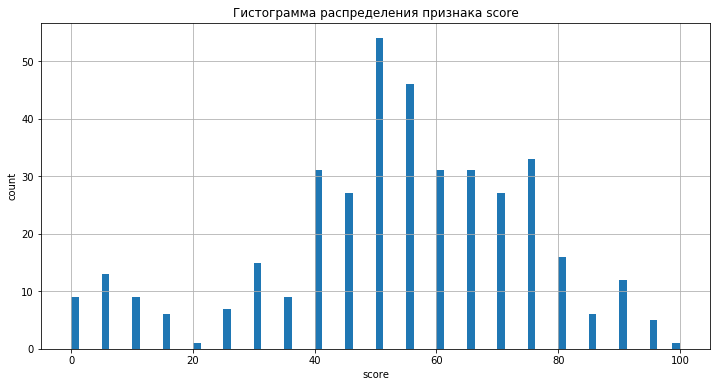

In [13]:
hist('score')

### absences — количество пропущенных занятий

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Количество пропусков: 11
Процент пропусков: 2.83%
25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0, Границы выбросов: [-12.0, 20.0]
Обнаружены выбросы (17):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
313,GP,F,19,U,NaN,NaN,3.0,2.0,services,other,reputation,other,2.0,2.0,NaN,no,NaN,NaN,no,no,yes,yes,yes,4.0,2.0,2.0,1.0,22.0,55.0
277,GP,M,18,U,GT3,T,4.0,4.0,NaN,services,home,mother,2.0,1.0,0.0,no,no,yes,yes,yes,yes,yes,no,3.0,2.0,4.0,3.0,22.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
320,GP,F,17,U,GT3,A,4.0,3.0,services,services,course,mother,1.0,2.0,NaN,no,yes,yes,no,yes,NaN,yes,yes,5.0,2.0,2.0,5.0,23.0,65.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
280,GP,M,17,U,NaN,A,4.0,NaN,services,other,home,mother,2.0,1.0,NaN,no,no,yes,yes,yes,yes,yes,NaN,4.0,NaN,4.0,5.0,30.0,40.0


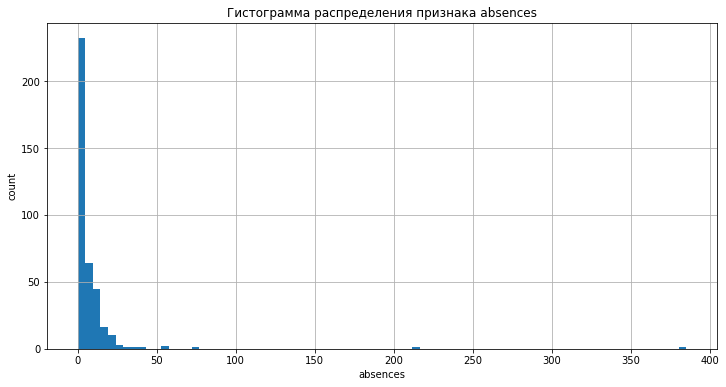

In [14]:
describe('absences')
hist('absences')
out_df = outliers('absences')
if not out_df.empty:
    print(f'Обнаружены выбросы ({len(out_df)}):')
    display(out_df.sort_values('absences'))
else:
    print('Выбросы не обнаружены')

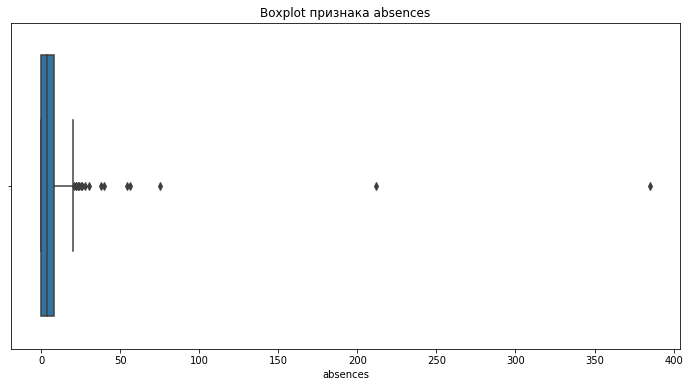

In [15]:
boxplot('absences')

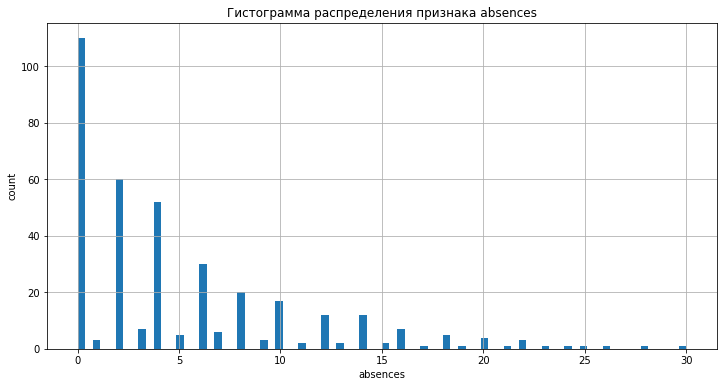

In [16]:
# Формула интерквартильного расстояния дает слишком много выбросов
# Подозрение вызывают только записи, где absences >= 30.
# С другой стороны эти студенты получили достаточно низкие баллы,
# а у студента с количеством пропусков 385 отец учитель и он мог находиться на домашнем обучении
stud = stud[stud['absences'].between(0, 30)]
hist('absences')

In [17]:
# Пропуски, в данном случае, можно заполнить медианным значением
stud['absences'].fillna(stud['absences'].median(), inplace=True)

In [18]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      371 non-null    object 
 1   sex         371 non-null    object 
 2   age         371 non-null    int64  
 3   address     357 non-null    object 
 4   famsize     347 non-null    object 
 5   Pstatus     330 non-null    object 
 6   Medu        368 non-null    float64
 7   Fedu        347 non-null    float64
 8   Mjob        353 non-null    object 
 9   Fjob        336 non-null    object 
 10  reason      354 non-null    object 
 11  guardian    341 non-null    object 
 12  traveltime  343 non-null    float64
 13  studytime   366 non-null    float64
 14  failures    349 non-null    float64
 15  schoolsup   362 non-null    object 
 16  famsup      335 non-null    object 
 17  paid        333 non-null    object 
 18  activities  357 non-null    object 
 19  nursery     356 non-null    o

### age — возраст ученика (от 15 до 22)

count    371.000000
mean      16.649596
std        1.256816
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

Количество пропусков: 0
Процент пропусков: 0.0%
25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0, Границы выбросов: [13.0, 21.0]
Обнаружены выбросы (1):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
247,GP,M,22,U,GT3,T,3.0,1.0,services,services,other,mother,1.0,1.0,3.0,no,no,no,no,no,no,yes,yes,5.0,4.0,5.0,1.0,16.0,40.0


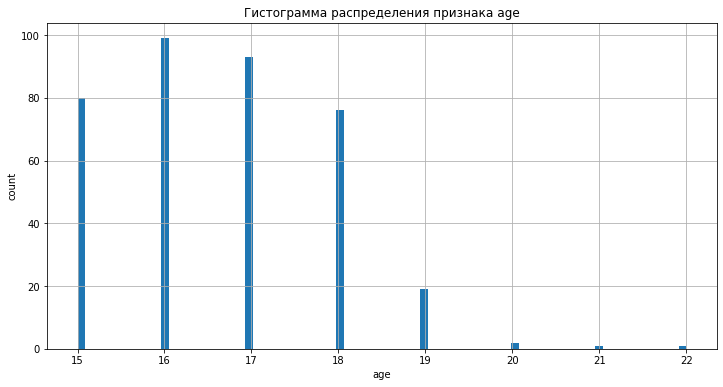

In [19]:
describe('age')
hist('age')
out_df = outliers('age')
if not out_df.empty:
    print(f'Обнаружены выбросы ({len(out_df)}):')
    display(out_df.sort_values('age'))
else:
    print('Выбросы не обнаружены')

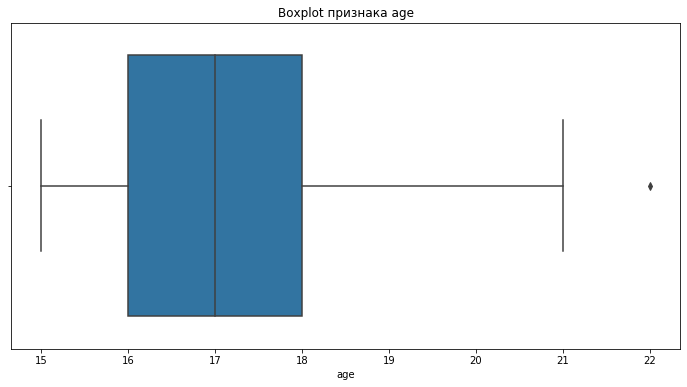

In [20]:
boxplot('age')

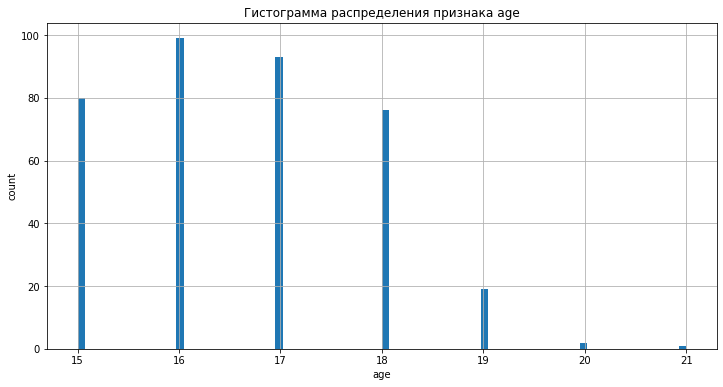

In [21]:
# Студенты старше 21 года определяются как выбросы, но в задании указан интервал от 15 до 22 лет.
# Ученик в возрасте 22 года - это, видимо какой-то отдельный случай (скорее всего влияет здоровье - 1) - удалям
stud = stud[stud['age'].between(0, 21)]
hist('age')

In [22]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      370 non-null    object 
 1   sex         370 non-null    object 
 2   age         370 non-null    int64  
 3   address     356 non-null    object 
 4   famsize     346 non-null    object 
 5   Pstatus     329 non-null    object 
 6   Medu        367 non-null    float64
 7   Fedu        346 non-null    float64
 8   Mjob        352 non-null    object 
 9   Fjob        335 non-null    object 
 10  reason      353 non-null    object 
 11  guardian    340 non-null    object 
 12  traveltime  342 non-null    float64
 13  studytime   365 non-null    float64
 14  failures    348 non-null    float64
 15  schoolsup   361 non-null    object 
 16  famsup      334 non-null    object 
 17  paid        332 non-null    object 
 18  activities  356 non-null    object 
 19  nursery     355 non-null    o

## Исследование номинативных признаков

In [23]:
def countplot(feature):
    fig, ax = plt.subplots()
    #  Добавляем подписи к осям:
    ax.set_xlabel(feature)
    ax.set_ylabel('count')
    ax.set_title(f'Кол-во значений признака {feature}')
    sns.set_style('whitegrid')
    _ = sns.countplot(x=feature, data=stud.fillna('NaN'), ax=ax)


def display_nan_rows(feature):
    df_nan = stud[stud[feature].isna()]
    if not df_nan.empty:
        print(f'Строки с пропусками {feature}:')
        display(df_nan.style.applymap(
            lambda x: 'color: red' if pd.isnull(x) else 'color: black'))
#    df_nan.style.applymap(lambda x: print(x))
#    display(df_nan)

In [24]:
# Преобразуем номинативные признаки в тип category
#stud[nom_features] = stud[nom_features].astype('category')
# stud.info()

In [25]:
# Теперь возможные значения
for feature in nom_features:
    print(f'Уникальные значения признака {feature}:', np.sort(
        stud[feature].dropna().unique()))

Уникальные значения признака higher: ['no' 'yes']
Уникальные значения признака famrel: [-1.  1.  2.  3.  4.  5.]
Уникальные значения признака famsize: ['GT3' 'LE3']
Уникальные значения признака famsup: ['no' 'yes']
Уникальные значения признака traveltime: [1. 2. 3. 4.]
Уникальные значения признака freetime: [1. 2. 3. 4. 5.]
Уникальные значения признака address: ['R' 'U']
Уникальные значения признака Fjob: ['at_home' 'health' 'other' 'services' 'teacher']
Уникальные значения признака Mjob: ['at_home' 'health' 'other' 'services' 'teacher']
Уникальные значения признака internet: ['no' 'yes']
Уникальные значения признака reason: ['course' 'home' 'other' 'reputation']
Уникальные значения признака paid: ['no' 'yes']
Уникальные значения признака studytime: [1. 2. 3. 4.]
Уникальные значения признака school: ['GP' 'MS']
Уникальные значения признака failures: [0. 1. 2. 3.]
Уникальные значения признака guardian: ['father' 'mother' 'other']
Уникальные значения признака schoolsup: ['no' 'yes']
Уник

In [26]:
# Для удобства рассмотрения предлагаю разделить номинативные признаки на 3 группы
# 1 - принимающие 2 значения (бинарные)
# 2 - те, что имеют отношения порядка (порядковые)
# 3 - где нет отношения порядка (категориальные)
bin_features = ['nursery', 'Pstatus', 'schoolsup', 'higher', 'paid', 'famsup',
                'romantic', 'address', 'sex', 'activities', 'school', 'famsize']
cat_features = ['guardian', 'Fjob', 'Mjob', 'reason']
ord_features = ['health', 'famrel', 'studytime', 'traveltime',
                'Fedu', 'Medu', 'freetime', 'failures', 'goout']

 ###  Бинарные признаки

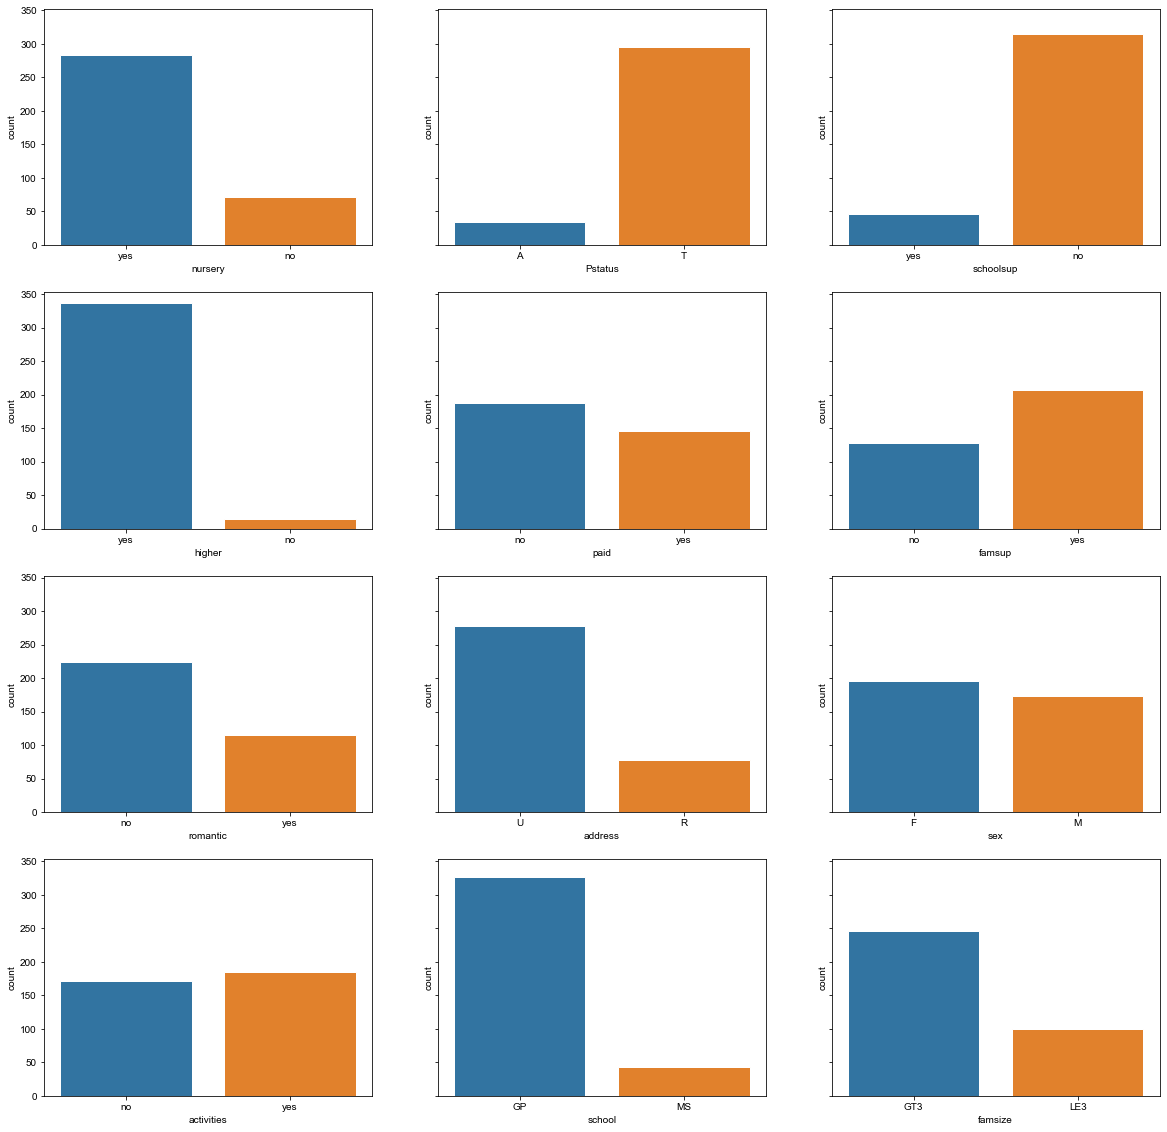

In [27]:
# Ищем выбросы
fig, axes = plt.subplots(
    int(np.ceil(len(bin_features) / 3)), 3, figsize=(20, 20), sharey=True)
for i in range(len(bin_features)):
    sns.set_style('whitegrid')
    sns.countplot(x=bin_features[i], data=stud, ax=axes[int(i / 3), i % 3])

In [28]:
# Все признаки принимаю 2 значения (можно потом закодировать 0 и 1). Выбросов нет.
# Имеется сильная несбалансированность по некоторым из них (higher, Pstatus, school), но пока рано делать какие-то выводы

In [29]:
# Посмотрим на количество пропусков в этих столбцах
for feature in bin_features:
    nan_count = stud[feature].isna().sum()
    print(
        f'Количество пропусков в столбце {feature} - {nan_count} ({round(nan_count * 100 / len(stud), 2)}%)')

Количество пропусков в столбце nursery - 15 (4.05%)
Количество пропусков в столбце Pstatus - 41 (11.08%)
Количество пропусков в столбце schoolsup - 9 (2.43%)
Количество пропусков в столбце higher - 19 (5.14%)
Количество пропусков в столбце paid - 38 (10.27%)
Количество пропусков в столбце famsup - 36 (9.73%)
Количество пропусков в столбце romantic - 31 (8.38%)
Количество пропусков в столбце address - 14 (3.78%)
Количество пропусков в столбце sex - 0 (0.0%)
Количество пропусков в столбце activities - 14 (3.78%)
Количество пропусков в столбце school - 0 (0.0%)
Количество пропусков в столбце famsize - 24 (6.49%)


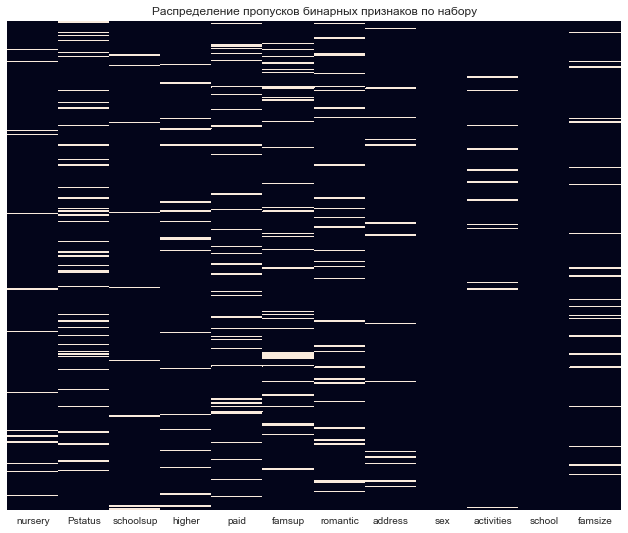

In [30]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Распределение пропусков бинарных признаков по набору')
_ = sns.heatmap(stud[bin_features].isnull(),
                cbar=False, ax=ax, yticklabels=False)

In [31]:
# Признаки содержат достаточно много пропусков.
# На этапе EDA пропуски можно оставить, но при построении модели, скорее всего, нужно будет удалить или заменить
# на значения, используя алгоритмы ML

### Категориальные признаки

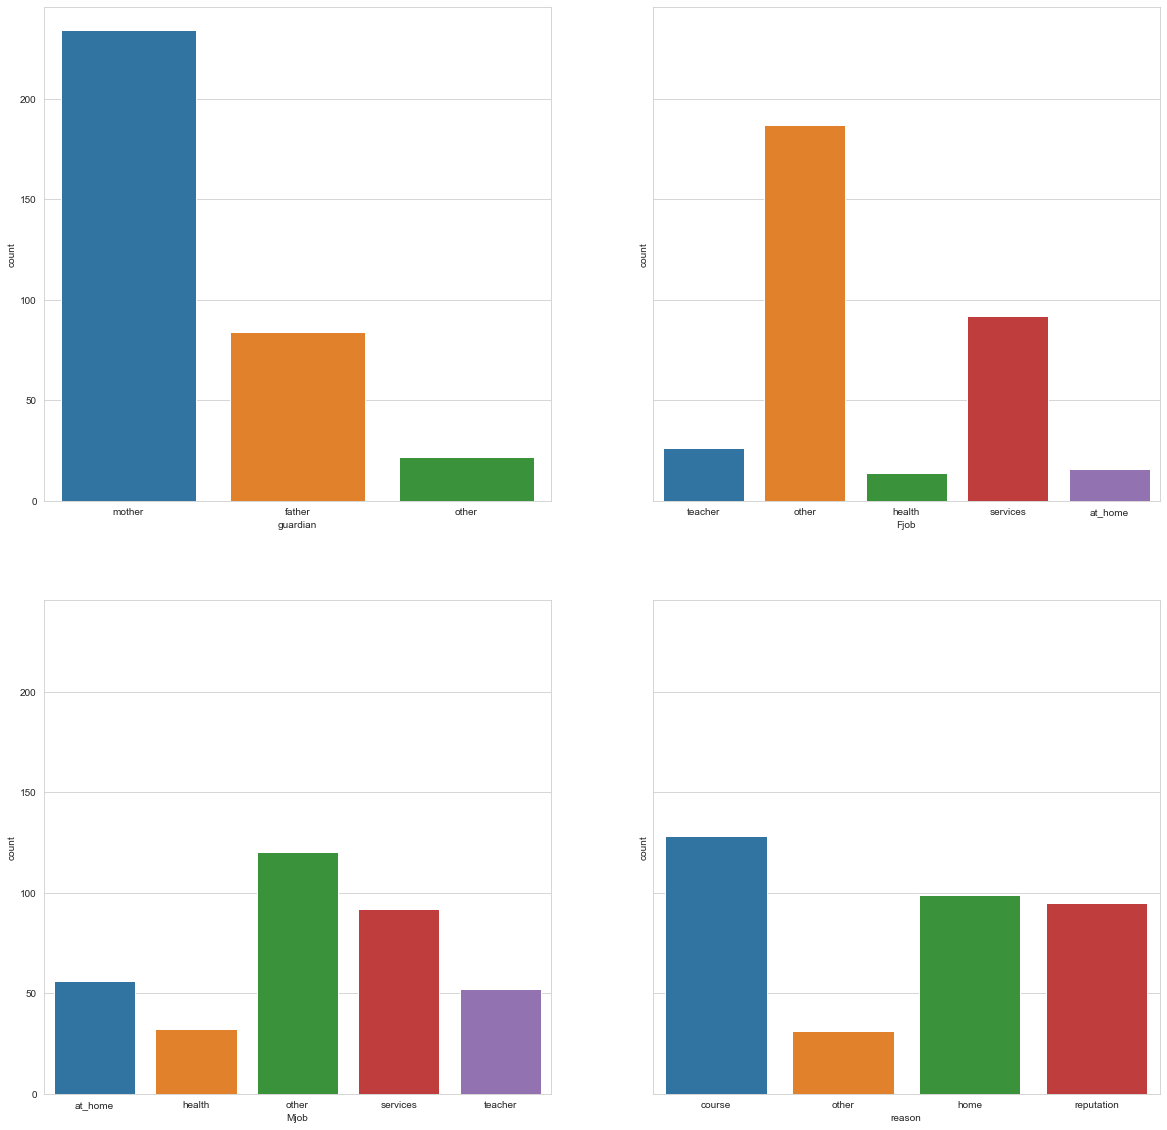

In [32]:
# Ищем выбросы
fig, axes = plt.subplots(
    int(np.ceil(len(cat_features) / 2)), 2, figsize=(20, 20), sharey=True)
for i in range(len(cat_features)):
    sns.set_style('whitegrid')
    sns.countplot(x=cat_features[i], data=stud, ax=axes[int(i / 2), i % 2])

In [33]:
# Все признаки принимают значения, соответствующие заданию. Выбросов нет.
# Можно закодировать, например one-hot

In [34]:
# Посмотрим на количество пропусков в этих столбцах
for feature in cat_features:
    nan_count = stud[feature].isna().sum()
    print(
        f'Количество пропусков в столбце {feature} - {nan_count} ({round(nan_count * 100 / len(stud), 2)}%)')

Количество пропусков в столбце guardian - 30 (8.11%)
Количество пропусков в столбце Fjob - 35 (9.46%)
Количество пропусков в столбце Mjob - 18 (4.86%)
Количество пропусков в столбце reason - 17 (4.59%)


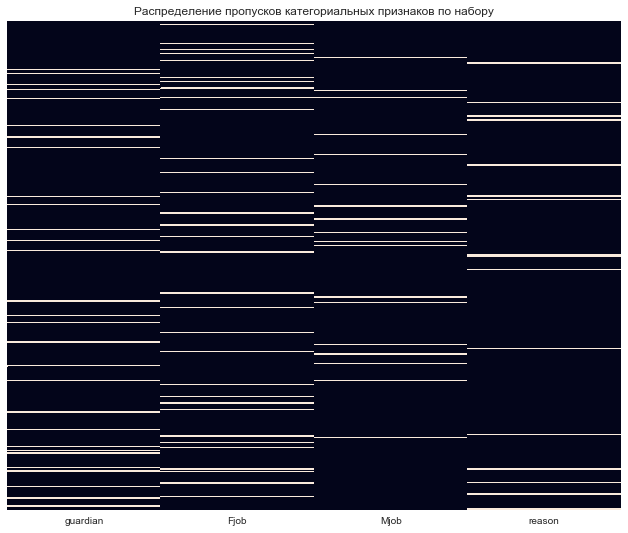

In [35]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Распределение пропусков категориальных признаков по набору')
_ = sns.heatmap(stud[cat_features].isnull(),
                cbar=False, ax=ax, yticklabels=False)

In [36]:
# Признаки содержат достаточно много пропусков.
# На этапе EDA пропуски можно оставить, но при построении модели, скорее всего, нужно будет удалить или заменить
# на значения, используя алгоритмы ML

### Порядковые признаки

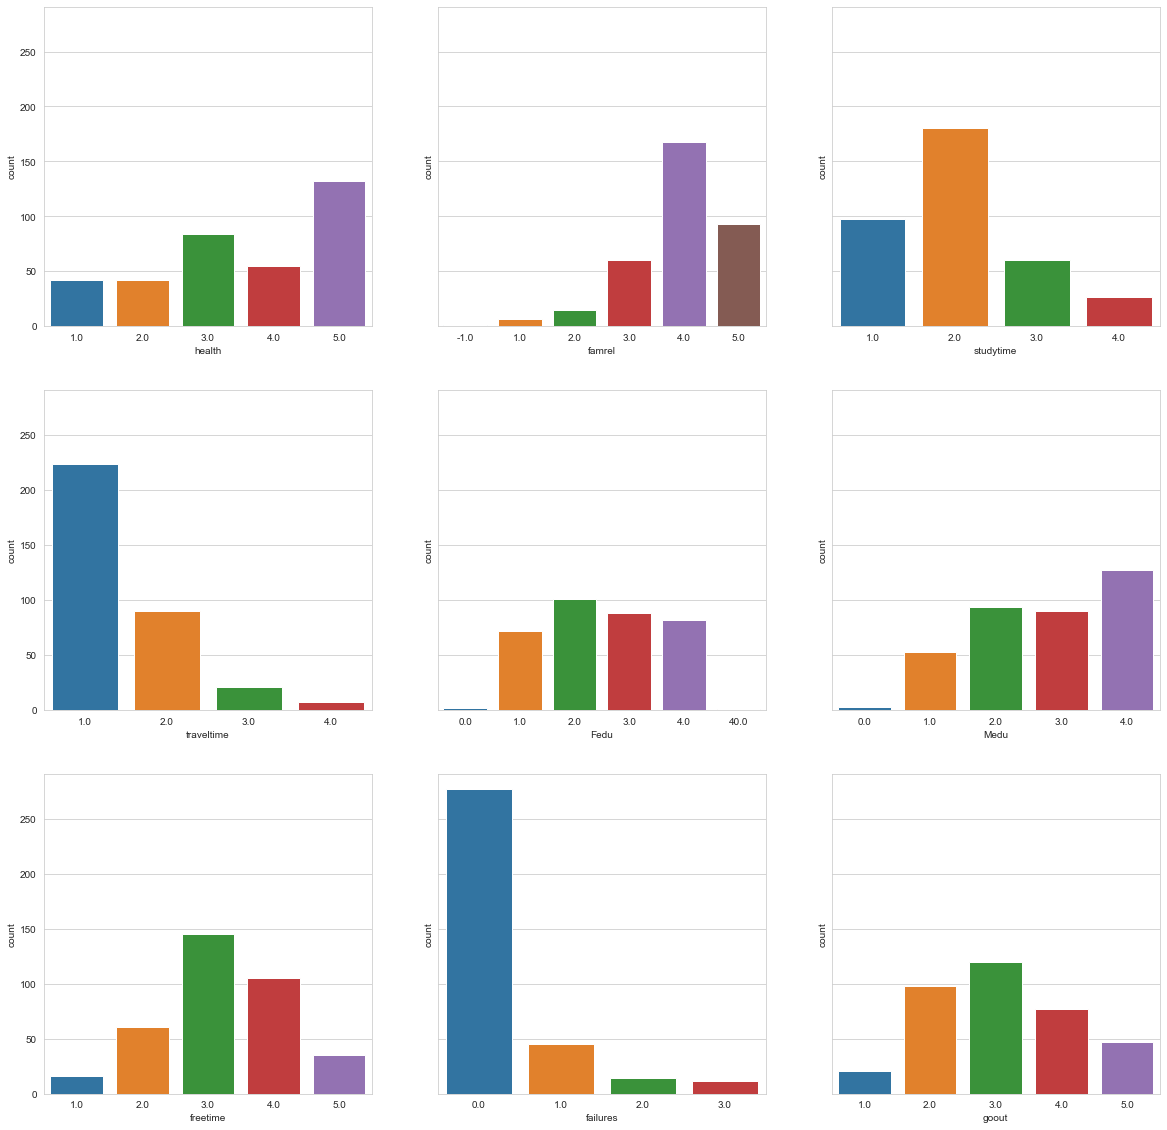

In [37]:
# Ищем выбросы
fig, axes = plt.subplots(
    int(np.ceil(len(ord_features) / 3)), 3, figsize=(20, 20), sharey=True)
for i in range(len(ord_features)):
    sns.set_style('whitegrid')
    sns.countplot(x=ord_features[i], data=stud, ax=axes[int(i / 3), i % 3])

In [38]:
# Видны значения, не соответствующие описанию признаков в задании.
# В признаке famrel - значение -1
display(stud[stud['famrel'] == -1])
# В признаке Fedu - значение 40
display(stud[stud['Fedu'] == 40])

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


In [39]:
# Эти записи удаляем
stud = stud[stud['Fedu'] != 40]
stud = stud[stud['famrel'] != -1]

In [40]:
# Посмотрим на количество пропусков в этих столбцах
for feature in ord_features:
    nan_count = stud[feature].isna().sum()
    print(
        f'Количество пропусков в столбце {feature} - {nan_count} ({round(nan_count * 100 / len(stud), 2)}%)')

Количество пропусков в столбце health - 15 (4.08%)
Количество пропусков в столбце famrel - 26 (7.07%)
Количество пропусков в столбце studytime - 5 (1.36%)
Количество пропусков в столбце traveltime - 28 (7.61%)
Количество пропусков в столбце Fedu - 24 (6.52%)
Количество пропусков в столбце Medu - 3 (0.82%)
Количество пропусков в столбце freetime - 8 (2.17%)
Количество пропусков в столбце failures - 22 (5.98%)
Количество пропусков в столбце goout - 7 (1.9%)


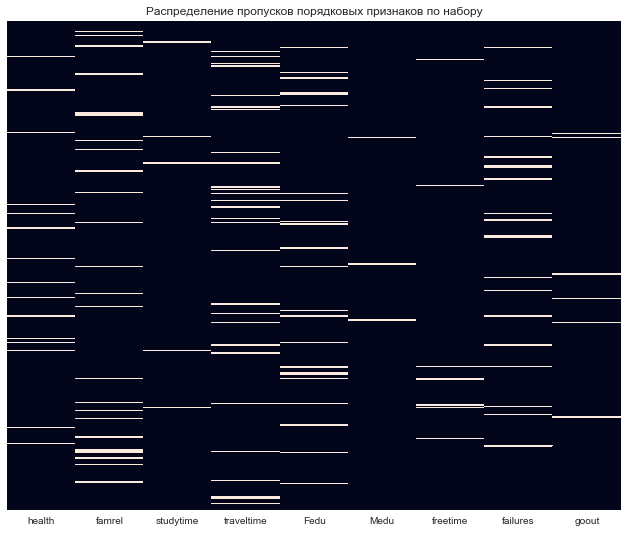

In [41]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Распределение пропусков порядковых признаков по набору')
_ = sns.heatmap(stud[ord_features].isnull(),
                cbar=False, ax=ax, yticklabels=False)

In [42]:
# Признаки содержат отнсительно немного пропусков.
# На этапе EDA пропуски можно оставить, но при построении модели, скорее всего, нужно будет удалить или заменить
# на значения, используя алгоритмы ML

## Корреляционный анализ количественных переменных

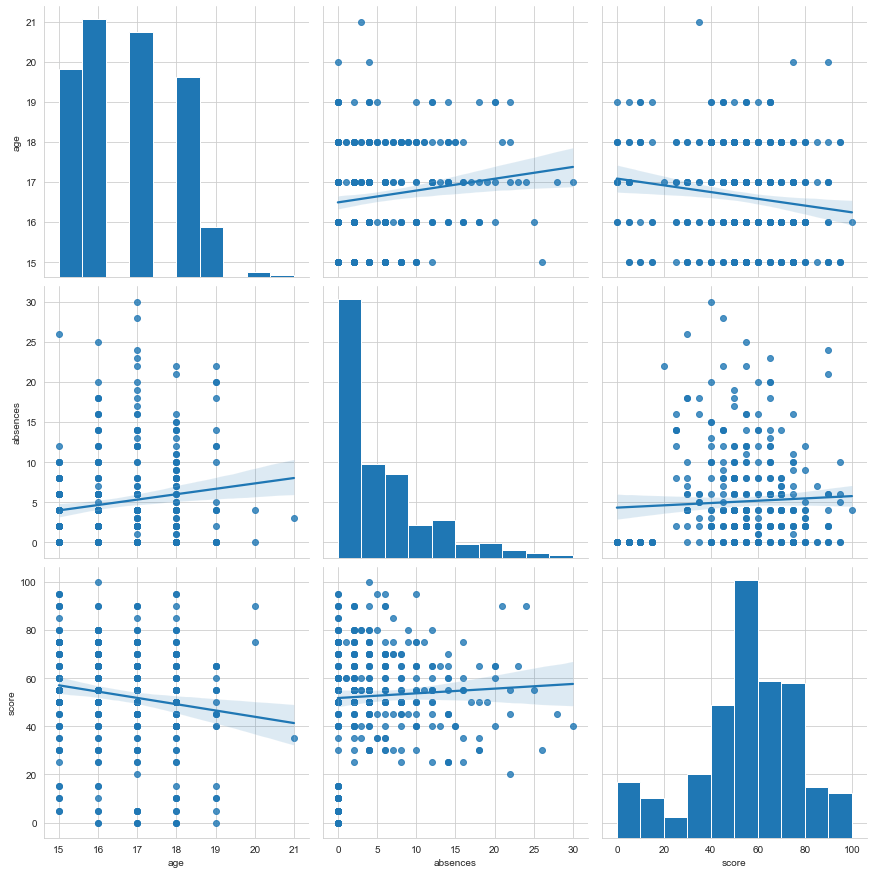

In [43]:
_ = sns.pairplot(stud[num_features], kind='reg', height=4)

In [44]:
stud[num_features].corr()

,age,absences,score
age,1.000000,0.140831,-0.148341
absences,0.140831,1.000000,0.052983
score,-0.148341,0.052983,1.000000


In [45]:
# Видна незначительная корреляция между признаками age и absences
# Похоже возраст влияет на целевую переменную

## Корреляционный анализ номинативных переменных

In [46]:
# Для проверки корреляции между номинативными переменными создадим
# новый набор данных и закодируем значения этих переменных
stud_model = stud.copy()
stud_model

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,MS,F,18,U,GT3,T,1.0,1.0,other,other,course,mother,NaN,2.0,1.0,no,no,no,yes,yes,yes,NaN,no,1.0,1.0,1.0,5.0,0.0,10.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


In [47]:
stud_model['school'] = stud_model['school'].apply(
    lambda x: 1 if x == 'GP' else 0 if x == 'MS' else x)
stud_model['sex'] = stud_model['sex'].apply(
    lambda x: 1 if x == 'M' else 0 if x == 'F' else x)
stud_model['address'] = stud_model['address'].apply(
    lambda x: 1 if x == 'U' else 0 if x == 'R' else x)
stud_model['famsize'] = stud_model['famsize'].apply(
    lambda x: 1 if x == 'GT3' else 0 if x == 'LE3' else x)
stud_model['Pstatus'] = stud_model['Pstatus'].apply(
    lambda x: 1 if x == 'A' else 0 if x == 'T' else x)

stud_model['schoolsup'] = stud_model['schoolsup'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['famsup'] = stud_model['famsup'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['paid'] = stud_model['paid'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['activities'] = stud_model['activities'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['nursery'] = stud_model['nursery'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['higher'] = stud_model['higher'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['internet'] = stud_model['internet'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['romantic'] = stud_model['romantic'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)

#stud_model = pd.get_dummies(stud_model, columns=cat_features)

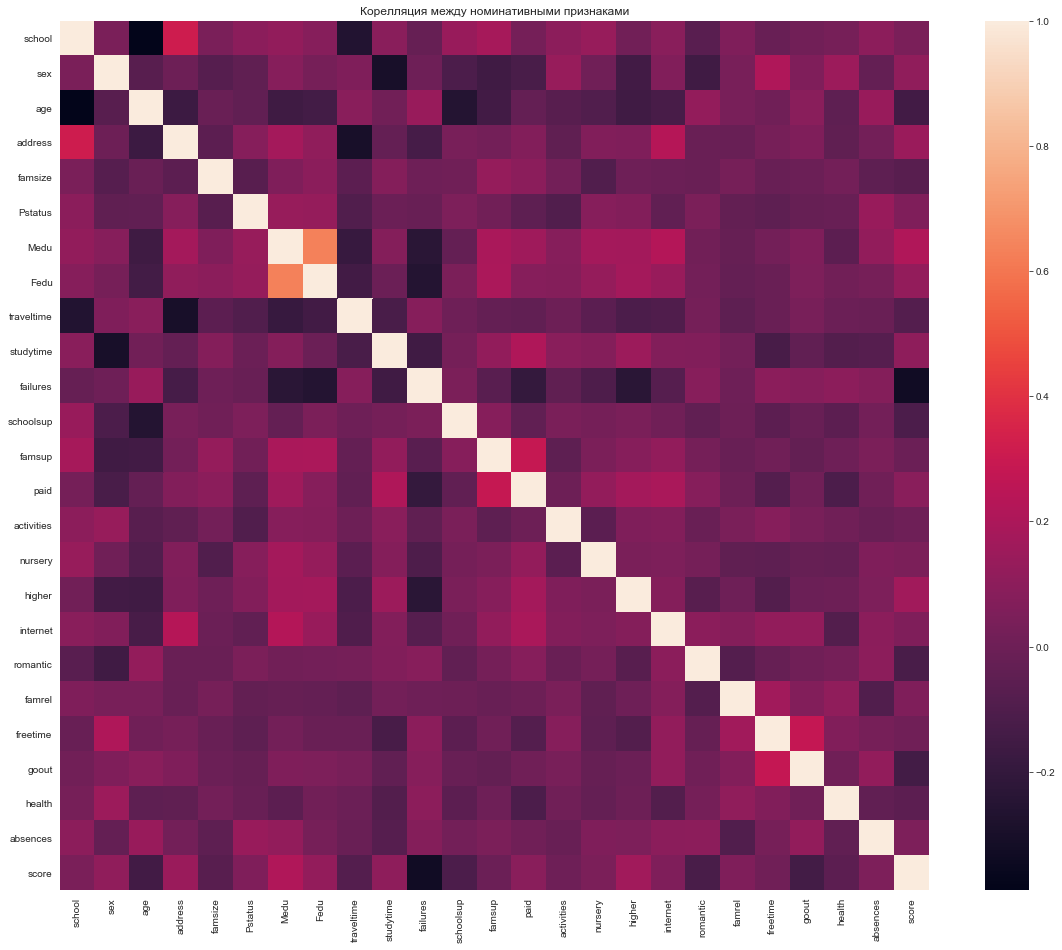

In [48]:
fig, ax = plt.subplots(figsize=(20, 16))
ax.set_title('Корелляция между номинативными признаками')
_ = sns.heatmap(stud_model.corr(), ax=ax, square=True)

In [49]:
stud_model.corr().style.applymap(lambda x: 'color: red' if abs(x) > 0.5 else '')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
school,1.000000,0.039504,-0.389480,0.313603,0.041125,0.097861,0.120494,0.082398,-0.259994,0.089040,-0.021158,0.137653,0.185203,0.027232,0.101947,0.132763,0.012454,0.088932,-0.064828,0.059958,-0.017123,0.014922,0.031969,0.103821,0.040128
sex,0.039504,1.000000,-0.073670,-0.002777,-0.079516,-0.042425,0.078435,0.030182,0.059452,-0.301963,0.004278,-0.111108,-0.153926,-0.119634,0.132762,0.008341,-0.145264,0.062287,-0.153563,0.038210,0.209777,0.056526,0.151500,-0.027521,0.113382
age,-0.389480,-0.073670,1.000000,-0.168280,-0.013712,-0.039250,-0.159923,-0.141616,0.090677,0.012504,0.140986,-0.256447,-0.148149,-0.026120,-0.072442,-0.091989,-0.155031,-0.124873,0.122392,0.035041,0.009909,0.092801,-0.048775,0.140831,-0.148341
address,0.313603,-0.002777,-0.168280,1.000000,-0.057044,0.082307,0.177007,0.113687,-0.298892,-0.031001,-0.132861,0.037987,0.020158,0.068073,-0.042252,0.065090,0.057167,0.230355,-0.009877,-0.018960,0.033336,0.059570,-0.047492,0.018677,0.146744
famsize,0.041125,-0.079516,-0.013712,-0.057044,1.000000,-0.070436,0.056906,0.095098,-0.054011,0.075716,0.001478,0.008133,0.126428,0.097204,0.019133,-0.094156,0.003146,-0.005085,-0.012246,0.033642,-0.018055,-0.005686,0.022161,-0.049594,-0.070096
Pstatus,0.097861,-0.042425,-0.039250,0.082307,-0.070436,1.000000,0.134638,0.126961,-0.092878,-0.008111,-0.018538,0.053661,0.012788,-0.049054,-0.095456,0.081558,0.067380,-0.038086,0.045430,-0.031593,-0.052361,-0.025157,-0.019170,0.138270,0.059858
Medu,0.120494,0.078435,-0.159923,0.177007,0.056906,0.134638,1.000000,0.635258,-0.183976,0.076040,-0.234831,-0.028088,0.193549,0.161582,0.080737,0.177686,0.172213,0.224076,0.013695,-0.021256,0.018602,0.060233,-0.058162,0.115511,0.217871
Fedu,0.082398,0.030182,-0.141616,0.113687,0.095098,0.126961,0.635258,1.000000,-0.147893,-0.007110,-0.258797,0.045317,0.196730,0.077586,0.077276,0.129386,0.175530,0.138776,0.019058,-0.029063,-0.013839,0.054893,0.012240,0.029521,0.122022
traveltime,-0.259994,0.059452,0.090677,-0.298892,-0.054011,-0.092878,-0.183976,-0.147893,1.000000,-0.120055,0.078452,0.001522,-0.026117,-0.039074,-0.003338,-0.059628,-0.111244,-0.097795,0.027583,-0.052896,-0.011121,0.038193,-0.009285,-0.010899,-0.084491
studytime,0.089040,-0.301963,0.012504,-0.031001,0.075716,-0.008111,0.076040,-0.007110,-0.120055,1.000000,-0.154946,0.023981,0.117281,0.209432,0.092720,0.073478,0.148026,0.069164,0.063977,0.022993,-0.123684,-0.039479,-0.086381,-0.077232,0.105984


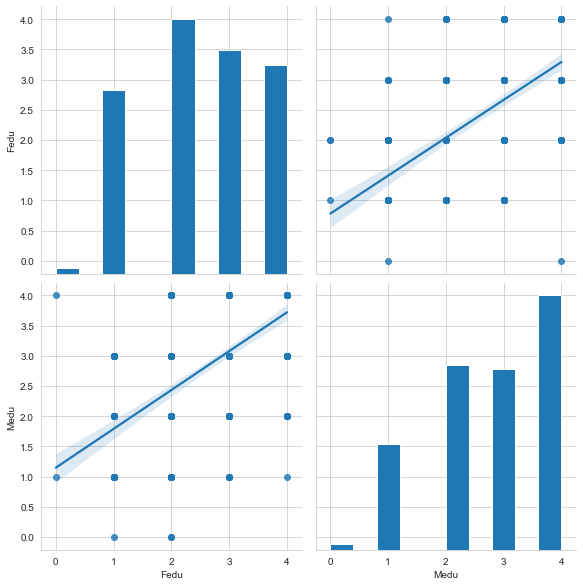

In [50]:
# Видна некоторая корреляция между образованием отца (Fedu) и образованием матери (Medu)
_ = sns.pairplot(stud_model[['Fedu', 'Medu']], kind='reg', height=4)

## Анализ влияния номинативных переменных на предсказываемую величину

In [51]:
def get_stat_dif(feature):
    cols = stud.loc[:, feature].dropna().value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        res = ttest_ind(stud.loc[stud.loc[:, feature] == comb[0], 'score'],
                        stud.loc[stud.loc[:, feature] == comb[1], 'score'])
        if res.pvalue <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', feature)
            return True
    return False


def get_boxplot(feature):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=feature, y='score',
                data=stud.loc[stud.loc[:, feature].isin(
                    stud.loc[:, feature].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + feature)
    plt.show()

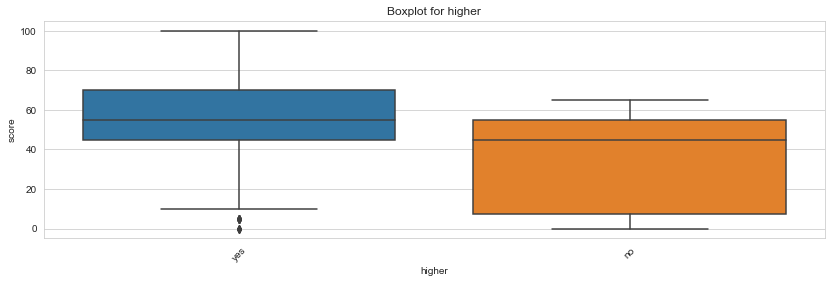

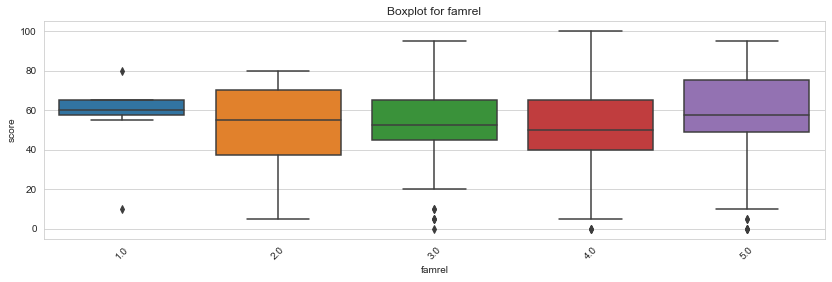

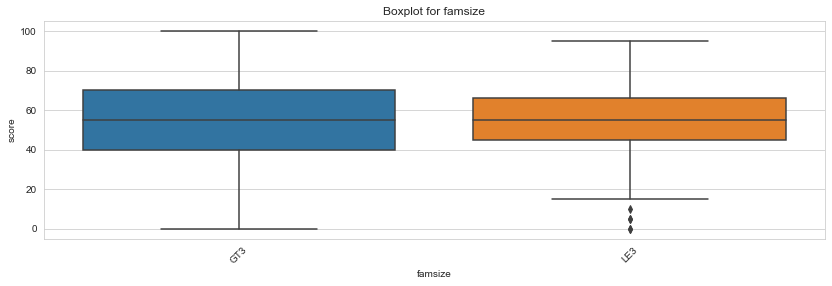

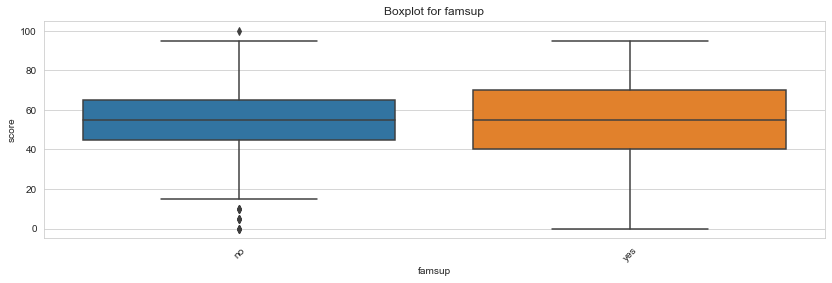

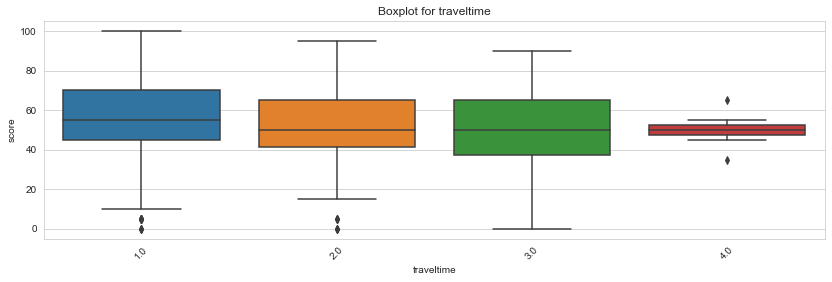

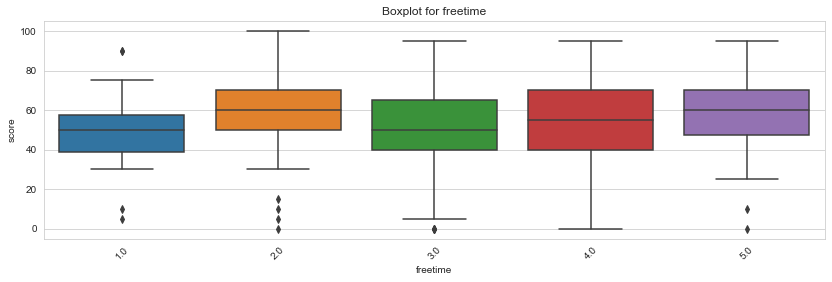

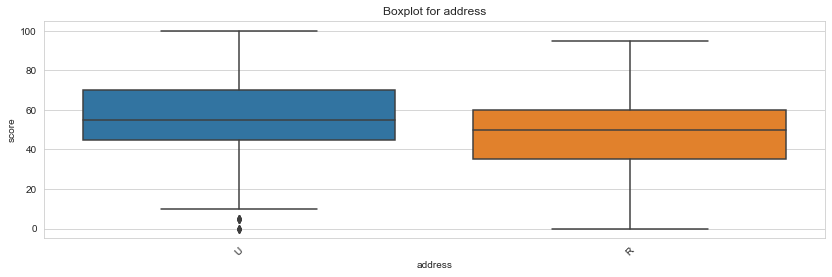

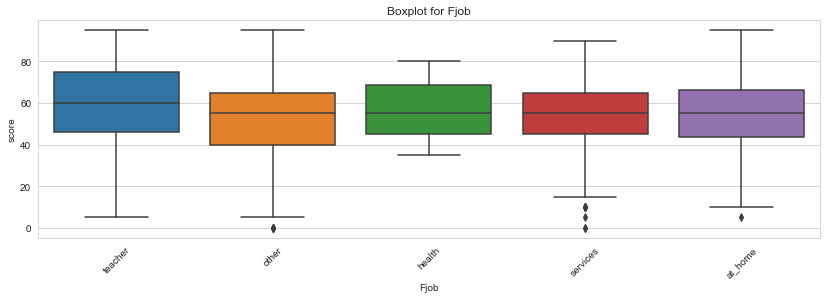

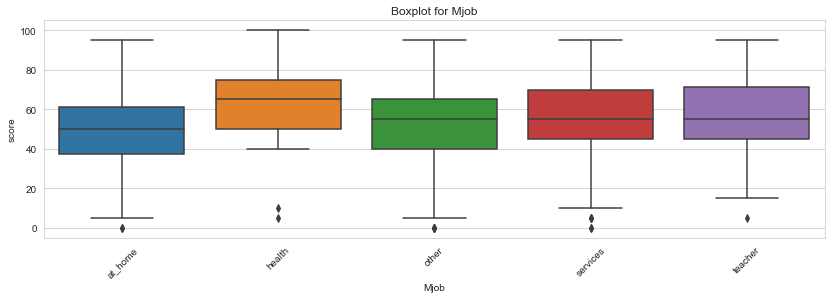

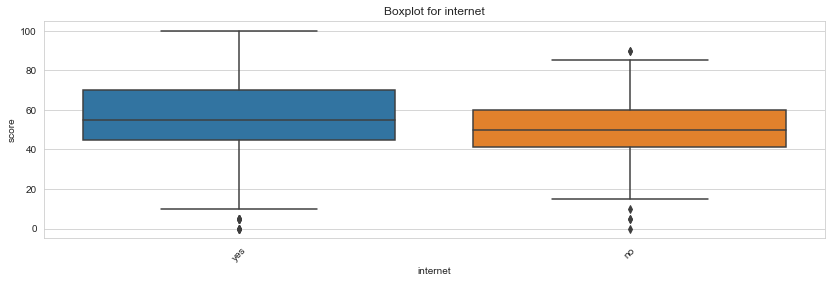

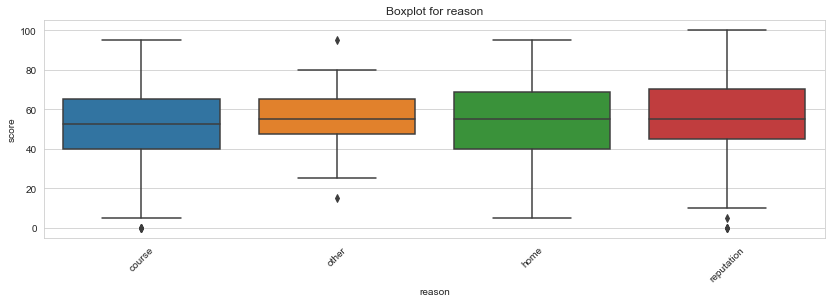

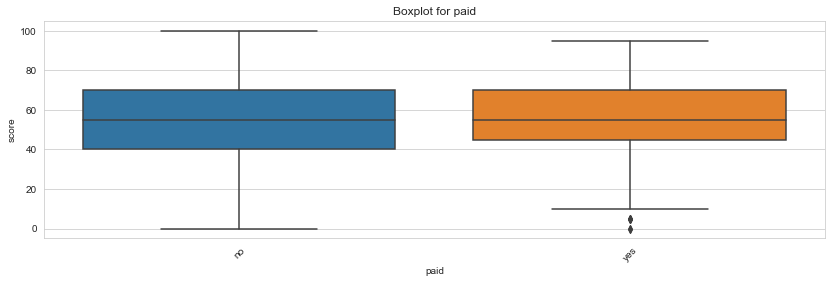

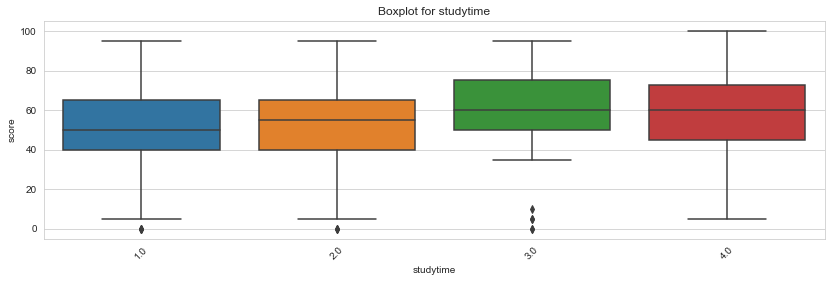

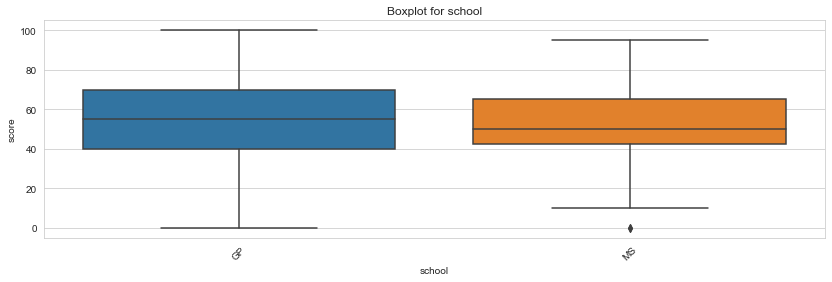

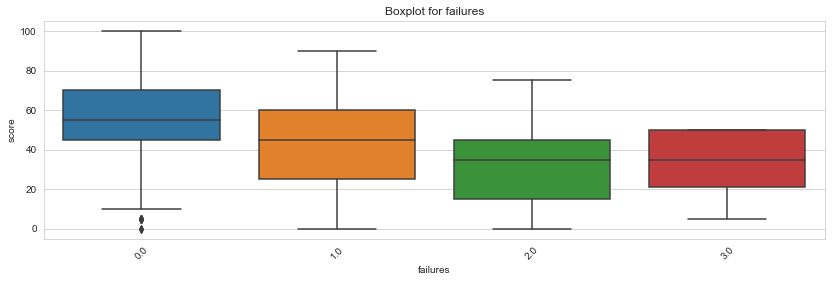

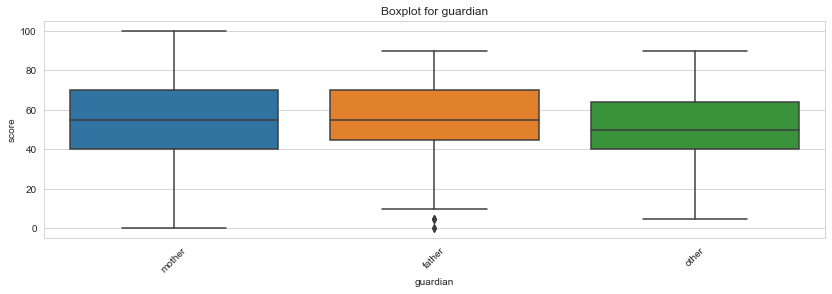

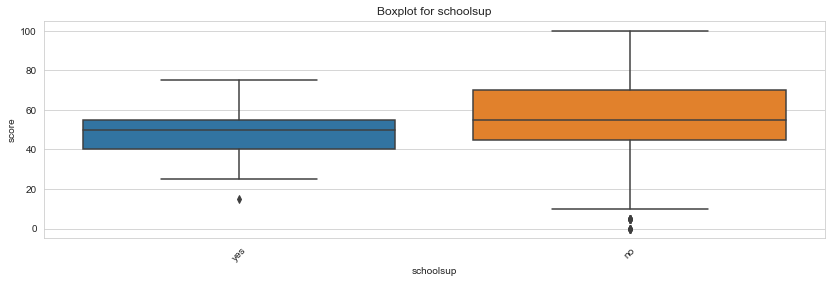

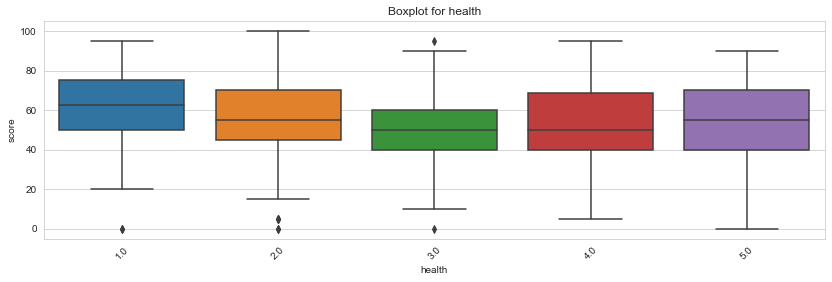

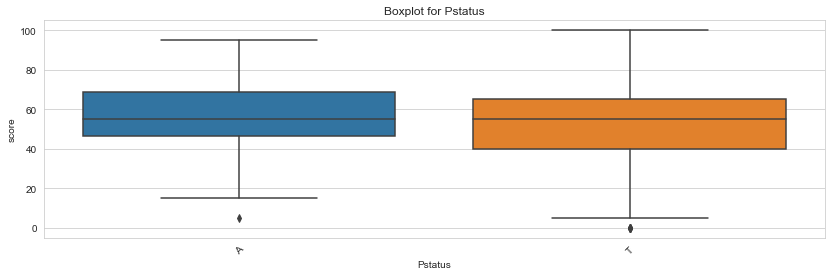

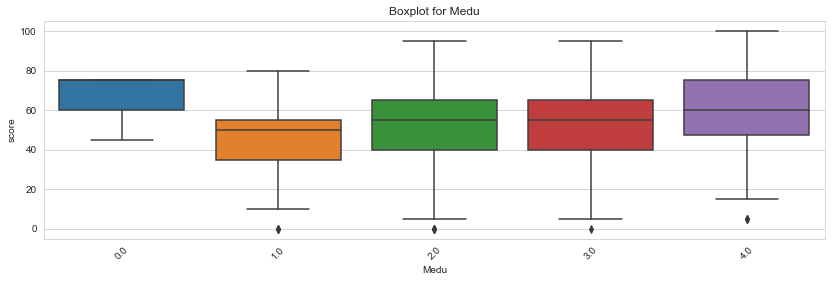

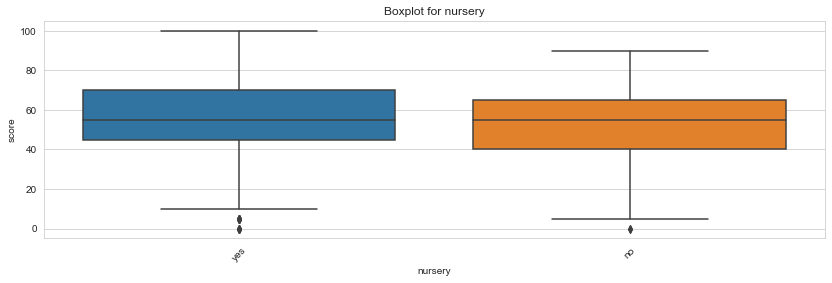

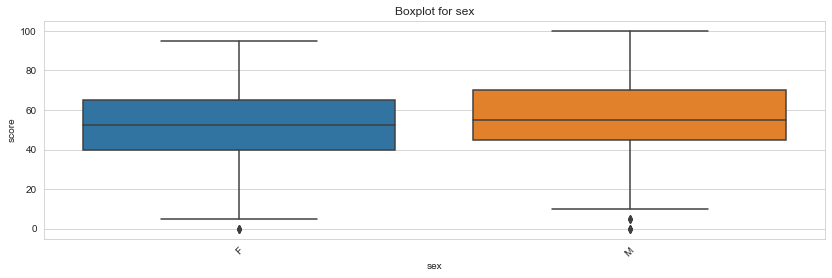

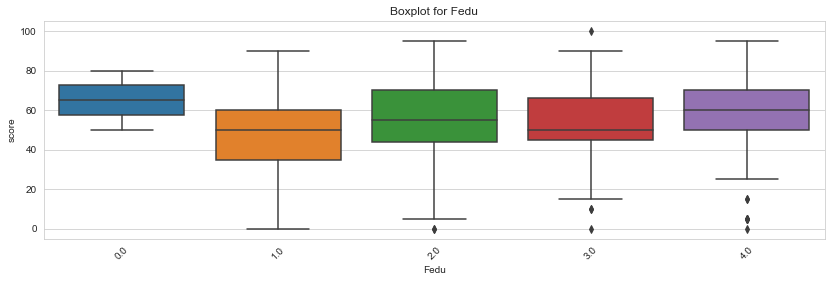

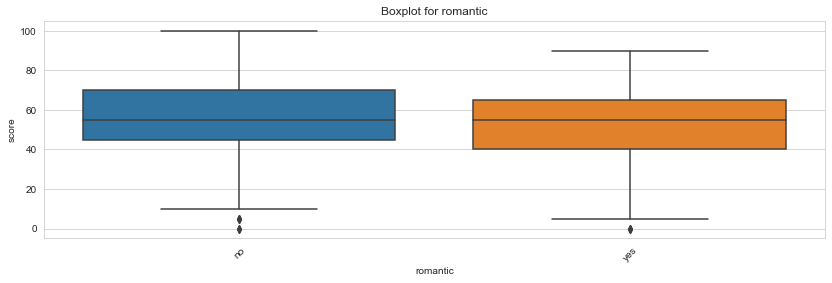

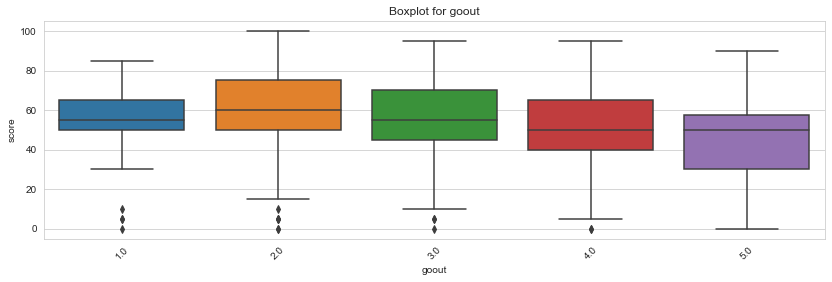

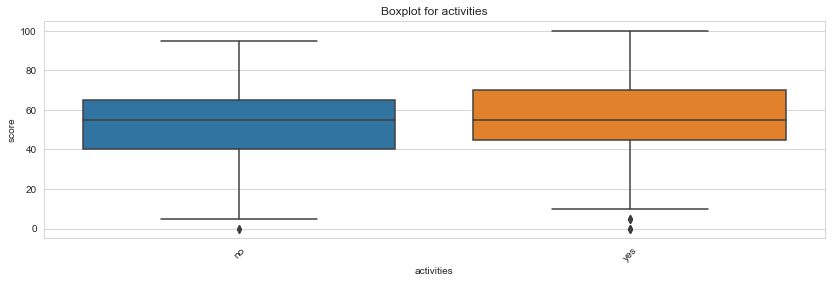

In [52]:
for col in nom_features[:]:
    get_boxplot(col)

In [58]:
# Отбоор признаков, влияющих на score
impotant_features = []
for feature in nom_features:
    if get_stat_dif(feature) == True:
        impotant_features.append(feature)
print(impotant_features)

Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки goout
['higher', 'address', 'Mjob', 'failures', 'schoolsup', 'Medu', 'sex', 'romantic', 'goout']


In [59]:
stud_math = stud[num_features + impotant_features].drop_duplicates()
stud_math.head(10)

,age,absences,score,higher,address,Mjob,failures,schoolsup,Medu,sex,romantic,goout
0,18,6.0,30.0,yes,U,at_home,0.0,yes,4.0,F,no,4.0
1,17,4.0,30.0,yes,U,at_home,0.0,no,1.0,F,no,3.0
2,15,10.0,50.0,yes,U,at_home,3.0,yes,1.0,F,NaN,2.0
3,15,2.0,75.0,yes,U,health,0.0,no,4.0,F,yes,2.0
4,16,4.0,50.0,yes,U,other,0.0,no,3.0,F,no,2.0
5,16,10.0,75.0,yes,U,services,0.0,no,4.0,M,no,2.0
6,16,0.0,55.0,yes,NaN,other,0.0,no,2.0,M,no,4.0
7,17,6.0,30.0,yes,U,other,0.0,yes,4.0,F,no,4.0
8,15,0.0,95.0,yes,U,services,0.0,no,3.0,M,no,2.0
9,15,0.0,75.0,yes,U,other,0.0,no,3.0,M,no,1.0


In [60]:
# О результирующем датасете
stud_math.info()
stud_math.describe(include=np.number)
stud_math.describe(include=np.object)
print('Пропуски по колонкам:')
display(stud_math.isna().sum())
print('Пропуски по строкам:')
display(stud_math.isna().sum(axis=1).sort_values(ascending=False).head(10))
rows_with_NaN = sum(stud_math.isna().sum(axis=1) > 0)
print(
    f'Количество строк содержащих пропуски: {rows_with_NaN} ({round(rows_with_NaN * 100 / len(stud_math), 2)}%)')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368 entries, 0 to 394
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        368 non-null    int64  
 1   absences   368 non-null    float64
 2   score      368 non-null    float64
 3   higher     349 non-null    object 
 4   address    354 non-null    object 
 5   Mjob       350 non-null    object 
 6   failures   346 non-null    float64
 7   schoolsup  359 non-null    object 
 8   Medu       365 non-null    float64
 9   sex        368 non-null    object 
 10  romantic   337 non-null    object 
 11  goout      361 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 37.4+ KB
Пропуски по колонкам:


age           0
absences      0
score         0
higher       19
address      14
Mjob         18
failures     22
schoolsup     9
Medu          3
sex           0
romantic     31
goout         7
dtype: int64

Пропуски по строкам:


54     3
92     3
158    2
261    2
204    2
372    2
75     2
239    2
241    2
181    2
dtype: int64

Количество строк содержащих пропуски: 103 (27.99%)


## Выводы

В результате EDA для анализа влияния параметров ученика на его оценку по экзамену по математике были получены слкдующие выводы:

1 - Выбросы обнаружены в столбцах: absences, age, famrel и Fedu. Причем в absences их достаточно много. Строки с выбросами удалены.

 2 - В данных достаточно много пропусков. Если записи с пропусками удалить может быть потеряна важная информация. 
    Так как заменять их для номинативных переменных на значения статистик считаю неправильным, думаю необходимо воспользоваться 
    методами ML для их заполнения.

3 - Обнаружена незначительная корреляция между параметрами age и absences (это логично, если предположить, что чем старше ученик,
тем у него больше соблазнов прогуливать занятия). Есть средняя корреляци я между признаками Fedu и Medu, что можно объяснить тем, что
скорее всего в большинстве семей уровень образования родителей относительно близок по уровню.

4 - С помощью теста Стьюдента с поправкой на множественную проверку гипотез Бонферони выявлены важные параметры для построения модели.
Это: higher, sex, Medu, schoolsup, goout, romantic, address, Mjob, failures
Такой способ отбора параметров не учитывает нелинейных зависимостей и зависимостей от комбинаций признаков, но для данного набора является приемлемой.